In [1]:
# imports 
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import ensemble, preprocessing, metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

In [2]:
x, y = functions.get_data(standard=False,minmax=True)

In [3]:
from sklearn.utils import resample
import copy

In [4]:
df = copy.copy(x)
df['Loan Status'] = y

In [5]:
# Separate majority and minority classes
df_majority = df[df['Loan Status'] ==0]
df_minority = df[df['Loan Status'] ==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=7451,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Loan Status'].value_counts()
# 1    7451
# 0    7451

1    7451
0    7451
Name: Loan Status, dtype: int64

In [6]:
# split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(df_upsampled.drop(columns='Loan Status'), df_upsampled['Loan Status'], test_size=0.33, random_state=10)


In [7]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

9984
9984
4918
4918


In [8]:
###### Random forest ######
scores = []

forest = ensemble.RandomForestClassifier(n_estimators = 10, max_depth = 10)
#forest_fit = forest.fit(x_train, y_train)

# training - get results
scores.append(cross_val_score(forest, x_train, y_train, cv = 10))

In [21]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

n_features = x_train.shape[1]

# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(5, 20, name='n_estimators'),
          Integer(1, 15, name='max_depth'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters
@use_named_args(space)
def objective(**params):
    forest.set_params(**params)

    return -np.mean(cross_val_score(forest, x_train, y_train, cv=10, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [22]:
from skopt import gp_minimize
forest_gp = gp_minimize(objective, space, n_calls=20, random_state=0)

"Best score=%.4f" % forest_gp.fun

/Users/ghost/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


'Best score=0.3351'

In [23]:
print("""Best parameters:
- n_estimators=%d
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (forest_gp.x[0], forest_gp.x[1], 
                            forest_gp.x[2], forest_gp.x[3], 
                            forest_gp.x[4]))

Best parameters:
- n_estimators=20
- max_depth=15
- max_features=34
- min_samples_split=2
- min_samples_leaf=1


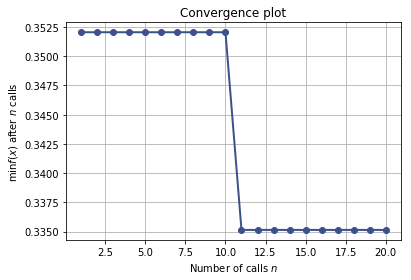

In [24]:
from skopt.plots import plot_convergence

plot_convergence(forest_gp)

In [25]:
forest = ensemble.RandomForestClassifier(n_estimators = 10, max_depth = 15, max_features=25, min_samples_split=2, min_samples_leaf=1)
forest_fit = forest.fit(x_train, y_train)



In [26]:
###### Random forest -- Feature Importance ######

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, x_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Current Loan Amount (0.221574)
2. Annual Income (0.109675)
3. Credit Score (0.097419)
4. Monthly Debt (0.096360)
5. Years of Credit History (0.081252)
6. Current Credit Balance (0.080468)
7. Maximum Open Credit (0.076400)
8. Months since last delinquent (0.070492)
9. Number of Open Accounts (0.056492)
10. Years in current job (0.038931)
11. Term (0.011975)
12. Number of Credit Problems (0.006997)
13. Home Ownership_Rent (0.006336)
14. Home Ownership_Home Mortgage (0.006334)
15. Bankruptcies (0.005990)
16. Purpose_Debt Consolidation (0.005415)
17. Home Ownership_Own Home (0.004711)
18. Purpose_Home Improvements (0.004266)
19. Tax Liens (0.003663)
20. Purpose_Other (0.003402)
21. Purpose_other (0.002561)
22. Purpose_Medical Bills (0.002318)
23. Purpose_Business Loan (0.001585)
24. Purpose_Buy a Car (0.001031)
25. Purpose_Buy House (0.000992)
26. Purpose_major_purchase (0.000960)
27. Purpose_moving (0.000835)
28. Purpose_Take a Trip (0.000600)
29. Purpose_small_busines

In [27]:
# predict
train_y_predicted = forest.predict(x_train)
test_y_predicted = forest.predict(x_test)

Training Accuracy: 0.9419070512820513
Testing Accuracy: 0.6525010166734445
AUC: 0.6522130626306027
F1: 0.6515814830791711


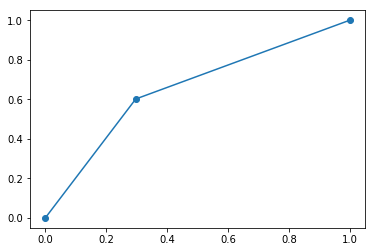

In [28]:
###### Random forest -- Evaluation ######

# accuracy
train_accuracy = metrics.accuracy_score(y_train, train_y_predicted)
test_accuracy = metrics.accuracy_score(y_test, test_y_predicted)
print("Training Accuracy: {0}".format(train_accuracy))
print("Testing Accuracy: {0}".format(test_accuracy))

# AUC index, excellent = 0.9~1, good = 0.8~0.9, soso = 0.7~0.8, not good = 0.6~0.7, bad = 0.6~0.7
# AUC is a good way for evaluation for binary classification problem
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_y_predicted)
auc = metrics.auc(fpr, tpr)
print("AUC: {0}".format(auc))

# F1
f1 = f1_score(y_test, test_y_predicted, average='weighted')
print("F1: {0}".format(f1))

# ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_y_predicted)
plt.plot(fpr,tpr,marker = 'o')
plt.show()

In [29]:
# write result to file
f = open("results/files/randomForest.txt", "w+")
f.write("Final F1 Score = {0} \n".format(f1))
f.write("Training Accuracy = {0} \n".format(train_accuracy))
f.write("Testing Accuracy = {0} \n".format(test_accuracy))
f.write("AUC = {0} \n".format(auc))
f.close()